In [1]:
import numpy as np
import scipy
from scipy.signal import hilbert

import colorednoise as cn
import statsmodels.api as sm
from joblib import Parallel, delayed
from sklearn.utils import resample
from lagged_autocoherence import generate_surrogate

import matplotlib.pyplot as plt

# Signal generation: null hypothesis = colored noise only
def generate_null_signal(T, n_trials, srate):
    n_timepoints = T * srate
    return cn.powerlaw_psd_gaussian(1, (n_trials, n_timepoints))

In [2]:
# Simulation parameters
T = 5  # trial duration in seconds
srate = 500
n_trials = 100
n_shuffles = 1000
alpha = 0.05

# Generate noise-only data (null)
null_signal = generate_null_signal(T, n_trials, srate)

# Generate surrogate distribution
surrogates = generate_surrogate(null_signal, n_shuffles=n_shuffles, method="phase", n_jobs=-1)

joint_energy_surrogates = np.mean(surrogates, axis=-1)
thresholds = np.percentile(joint_energy_surrogates, 95, axis=-1)

In [3]:
lags = np.arange(0.1, 1.6, 0.1)
f_min = 1
f_max = 100

freqs, psd = scipy.signal.welch(null_signal, fs=srate, window='hann',
                                nperseg=srate, noverlap=int(srate / 2), nfft=srate * 2, detrend='constant',
                                return_onesided=True, scaling='density', axis=- 1, average='mean')
idx = (freqs >= f_min) & (freqs <= f_max)
freqs = freqs[idx]
psd = psd[:, idx]

freqs, surr_psd = scipy.signal.welch(surrogates, fs=srate, window='hann',
                                     nperseg=srate, noverlap=int(srate / 2), nfft=srate * 2, detrend='constant',
                                     return_onesided=True, scaling='density', axis=- 1, average='mean')
idx = (freqs >= f_min) & (freqs <= f_max)
freqs = freqs[idx]
surr_psd = surr_psd[:, :, idx]

In [4]:
df = np.diff(freqs)[0]
n_pts = null_signal.shape[-1]
T = n_pts * 1 / srate
time = np.linspace(0, T, int(T * srate))
n_lags = len(lags)
padd_signal = np.hstack([np.zeros((n_trials, n_pts)), null_signal, np.zeros((n_trials, n_pts))])
signal_fft = np.fft.rfft(padd_signal, axis=-1)
fft_frex = np.fft.rfftfreq(padd_signal.shape[-1], d=1 / srate)
sigma = df * .5


def lhc_extended(freq):
    f_num = np.zeros((n_trials, n_lags))
    f_denom = np.zeros((n_trials, n_lags))
    f_lhc = np.zeros((n_trials, n_lags))

    # Gaussian kernel centered on frequency with width defined
    # by requested frequency resolution
    kernel = np.exp(-((fft_frex - freq) ** 2 / (2.0 * sigma ** 2)))

    # Multiply Fourier-transformed signal by kernel
    fsignal_fft = np.multiply(signal_fft, kernel)
    # Reverse Fourier to get bandpass filtered signal
    f_signal = np.fft.irfft(fsignal_fft, axis=-1)

    # Get analytic signal of bandpass filtered data (phase and amplitude)
    analytic_signal = hilbert(f_signal, N=None, axis=-1)
    # Cut off padding
    analytic_signal = analytic_signal[:, n_pts:2 * n_pts]

    for l_idx, lag in enumerate(lags):
        # Duration of this lag in s
        lag_dur_s = np.max([lag / freq, 1/srate])

        # Number of evaluations
        n_evals = int(np.floor(T / lag_dur_s))
        # Remaining time
        diff = T - (n_evals * lag_dur_s)

        # Start time
        start_time = time[0]
        # Evaluation times (ms)
        eval_times = np.linspace(start_time, T - diff, n_evals + 1)[:-1]
        # Evaluation time points
        eval_pts = np.searchsorted(time, eval_times)

        # Number of points between the first and next evaluation time points
        n_range = eval_pts[1] - eval_pts[0]
        # Analytic signal at n=0...n_evals-1 evaluation points, and m=0..n_range time points in between
        f1 = analytic_signal[:,eval_pts[:-1, np.newaxis] + np.arange(n_range)]
        # Analytic signal at n=1...n_evals evaluation points, and m=0..n_range time points in between
        f2 = analytic_signal[:,eval_pts[1:, np.newaxis] + np.arange(n_range)]

        # Calculate the phase difference and amplitude product
        phase_diff = np.angle(f2) - np.angle(f1)
        amp_prod = np.abs(f1) * np.abs(f2)

        # Lagged autocoherence
        num = np.sum(amp_prod * np.exp(complex(0, 1) * phase_diff), axis=1)
        f1_pow = np.power(f1, 2)
        f2_pow = np.power(f2, 2)
        denom = np.sqrt(np.sum(np.abs(f1_pow), axis=1) * np.sum(np.abs(f2_pow), axis=1))

        lhc = np.abs(num / denom)
        
        f_num[:,l_idx]=np.mean(np.abs(num), axis=-1)
        f_denom[:, l_idx] = np.mean(denom, axis=-1)
        f_lhc[:, l_idx] = np.mean(lhc, axis=-1)
    return f_num, f_denom, f_lhc

In [5]:
# Frequencies to test
test_freqs = [2.5, 5, 10, 25, 50]

fprs = []

for f in test_freqs:
    num, denom, lhc = lhc_extended(f)
    
    lag_fpr = []
    
    for l_idx, lag in enumerate(lags):
        false_positives = denom[:, l_idx] > thresholds
        fpr = false_positives.mean()
        lag_fpr.append(fpr)

    fprs.append(lag_fpr)

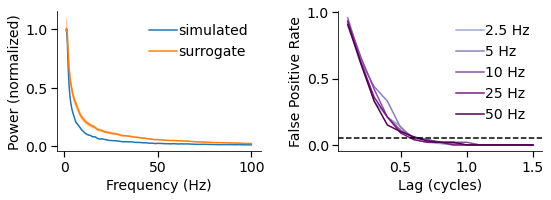

In [9]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

freq_colors = plt.get_cmap('BuPu', len(test_freqs)+3)

fig=plt.figure(figsize=(8, 3))

m_psd = np.mean(psd, axis=0)
sd_psd = np.std(psd, axis=0)
m_psd /= np.max(m_psd)
sd_psd /= np.max(m_psd)

m_surr_psd = np.mean(np.mean(surr_psd, axis=1), axis=0)
sd_surr_psd = np.mean(np.std(surr_psd, axis=1), axis=0)
m_surr_psd /= np.max(m_surr_psd)
sd_surr_psd /= np.max(m_surr_psd)

ax = plt.subplot(1, 2, 1)
ax.plot(freqs, m_psd, label='simulated')
ax.fill_between(freqs, m_psd - sd_psd, m_psd + sd_psd, alpha=0.5)

ax.plot(freqs, m_surr_psd, label='surrogate')
ax.fill_between(freqs, m_surr_psd - sd_surr_psd, m_surr_psd + sd_surr_psd, alpha=0.5)

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (normalized)')
ax.legend()

ax = plt.subplot(1, 2, 2)
for i, f in enumerate(test_freqs):
    ax.plot(lags, fprs[i], color=freq_colors(i+3), label=f'{f} Hz')
ax.axhline(0.05, color='k', linestyle='--')
ax.set_xlabel('Lag (cycles)')
ax.set_ylabel('False Positive Rate')
ax.legend()

plt.tight_layout()
fig.savefig('../output/figures/figure_3.pdf')